# Conditional Autoencoder for Asset Pricing - Data Preparation

In [1]:
from pathlib import Path

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.regression.rolling import RollingOLS
import statsmodels.api as sm

In [2]:
idx = pd.IndexSlice
sns.set_style('whitegrid')

## Load Data

### Prices

In [3]:
prices = pd.read_hdf('data.h5', 'stocks/prices/adjusted')

In [4]:
prices.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 14110095 entries, ('A', Timestamp('1999-11-18 00:00:00')) to ('ZYME', Timestamp('2019-12-31 00:00:00'))
Data columns (total 5 columns):
 #   Column  Non-Null Count     Dtype  
---  ------  --------------     -----  
 0   close   14110095 non-null  float64
 1   high    14110095 non-null  float64
 2   low     14110095 non-null  float64
 3   open    14110095 non-null  float64
 4   volume  14110095 non-null  float64
dtypes: float64(5)
memory usage: 593.0+ MB


### Metadata

In [5]:
metadata = pd.read_hdf('data.h5', 'stocks/info').rename(columns=str.lower)

In [6]:
metadata.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4323 entries, ZYNE to A
Columns: 106 entries, zip to trailingpe
dtypes: bool(2), float64(72), int64(3), object(29)
memory usage: 3.5+ MB


### Select tickers with metadata

In [7]:
sectors = (metadata.sector.value_counts() > 50).index

In [8]:
tickers_with_errors = ['FTAI', 'AIRT', 'CYBR', 'GRAF', 'KTB']

In [9]:
tickers_with_metadata = metadata[metadata.sector.isin(sectors) & 
                                 metadata.marketcap.notnull() &
                                 metadata.sharesoutstanding.notnull() & 
                                (metadata.sharesoutstanding > 0)].index.drop(tickers_with_errors)

In [10]:
metadata = metadata.loc[tickers_with_metadata, ['sector', 'sharesoutstanding', 'marketcap']]
metadata.index.name = 'ticker'

In [11]:
prices = prices.loc[idx[tickers_with_metadata, :], :]

In [12]:
prices.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 13808730 entries, ('A', Timestamp('1999-11-18 00:00:00')) to ('ZYME', Timestamp('2019-12-31 00:00:00'))
Data columns (total 5 columns):
 #   Column  Non-Null Count     Dtype  
---  ------  --------------     -----  
 0   close   13808730 non-null  float64
 1   high    13808730 non-null  float64
 2   low     13808730 non-null  float64
 3   open    13808730 non-null  float64
 4   volume  13808730 non-null  float64
dtypes: float64(5)
memory usage: 579.6+ MB


In [13]:
metadata.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4082 entries, ZYNE to A
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   sector             4082 non-null   object 
 1   sharesoutstanding  4082 non-null   float64
 2   marketcap          4082 non-null   float64
dtypes: float64(2), object(1)
memory usage: 127.6+ KB


In [14]:
close = prices.close.unstack('ticker').sort_index()
close.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7559 entries, 1990-01-02 to 2019-12-31
Columns: 3657 entries, A to ZYME
dtypes: float64(3657)
memory usage: 211.0 MB


In [15]:
volume = prices.volume.unstack('ticker').sort_index()
volume.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7559 entries, 1990-01-02 to 2019-12-31
Columns: 3657 entries, A to ZYME
dtypes: float64(3657)
memory usage: 211.0 MB


### Create weekly returns

In [16]:
returns = (prices.close
           .unstack('ticker')
           .resample('W-FRI').last()
           .sort_index().pct_change().iloc[1:])
returns.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1565 entries, 1990-01-12 to 2020-01-03
Freq: W-FRI
Columns: 3657 entries, A to ZYME
dtypes: float64(3657)
memory usage: 43.7 MB


In [17]:
dates = returns.index

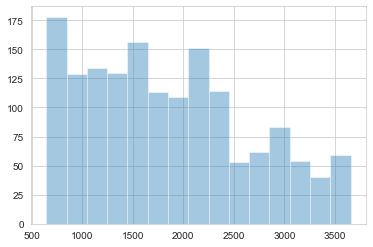

In [18]:
sns.distplot(returns.count(1), kde=False);

In [19]:
with pd.HDFStore('autoencoder.h5') as store:
    store.put('close', close)
    store.put('volume', volume)
    store.put('returns', returns)
    store.put('metadata', metadata)

## Factor Engineering

In [20]:
MONTH = 21

### Price Trend

#### Short-Term Reversal

1-month cumulative return

In [21]:
dates[:5]

DatetimeIndex(['1990-01-12', '1990-01-19', '1990-01-26', '1990-02-02',
               '1990-02-09'],
              dtype='datetime64[ns]', name='date', freq='W-FRI')

In [22]:
mom1m = close.pct_change(periods=MONTH).resample('W-FRI').last().stack().to_frame('mom1m')
mom1m.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 2871156 entries, (Timestamp('1990-02-02 00:00:00', freq='W-FRI'), 'AA') to (Timestamp('2020-01-03 00:00:00', freq='W-FRI'), 'ZYME')
Data columns (total 1 columns):
 #   Column  Dtype  
---  ------  -----  
 0   mom1m   float64
dtypes: float64(1)
memory usage: 32.9+ MB


In [23]:
mom1m.squeeze().to_hdf('autoencoder.h5', 'factor/mom1m')

#### Stock Momentum

11-month cumulative returns ending 1-month before month end

In [24]:
mom12m = (close
            .pct_change(periods=11 * MONTH)
            .shift(MONTH)
            .resample('W-FRI')
            .last()
            .stack()
            .to_frame('mom12m'))

In [25]:
mom12m.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 2700206 entries, (Timestamp('1991-01-04 00:00:00', freq='W-FRI'), 'AA') to (Timestamp('2020-01-03 00:00:00', freq='W-FRI'), 'ZYME')
Data columns (total 1 columns):
 #   Column  Non-Null Count    Dtype  
---  ------  --------------    -----  
 0   mom12m  2700206 non-null  float64
dtypes: float64(1)
memory usage: 30.9+ MB


In [26]:
mom12m.to_hdf('autoencoder.h5', 'factor/mom12m')

#### Momentum Change

Cumulative return from months t-6 to t-1 minus months t-12 to t-7.

In [27]:
chmom = (close
         .pct_change(periods=6 * MONTH)
         .sub(close.pct_change(periods=6 * MONTH).shift(6 * MONTH))
         .resample('W-FRI')
         .last()
         .stack()
         .to_frame('chmom'))

In [28]:
chmom.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 2700206 entries, (Timestamp('1991-01-04 00:00:00', freq='W-FRI'), 'AA') to (Timestamp('2020-01-03 00:00:00', freq='W-FRI'), 'ZYME')
Data columns (total 1 columns):
 #   Column  Non-Null Count    Dtype  
---  ------  --------------    -----  
 0   chmom   2700206 non-null  float64
dtypes: float64(1)
memory usage: 30.9+ MB


In [29]:
chmom.to_hdf('autoencoder.h5', 'factor/chmom')

#### Industry Momentum

Equal-weighted avg. industry 12-month returns

In [30]:
indmom = (close.pct_change(12*MONTH)
          .resample('W-FRI')
          .last()
          .stack()
          .to_frame('close')
          .join(metadata[['sector']]).groupby(['date', 'sector'])
          .close.mean()
          .to_frame('indmom')
          .reset_index())

In [31]:
indmom.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18362 entries, 0 to 18361
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    18362 non-null  datetime64[ns]
 1   sector  18362 non-null  object        
 2   indmom  18362 non-null  float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 430.5+ KB


In [32]:
indmom = (returns
          .stack()
          .to_frame('ret')
          .join(metadata[['sector']])
          .reset_index()
          .merge(indmom)
          .set_index(['date', 'ticker'])
          .loc[:, ['indmom']])

In [33]:
indmom.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 2849516 entries, (Timestamp('1991-01-04 00:00:00'), 'AA') to (Timestamp('2020-01-03 00:00:00'), 'IIM')
Data columns (total 1 columns):
 #   Column  Non-Null Count    Dtype  
---  ------  --------------    -----  
 0   indmom  2849516 non-null  float64
dtypes: float64(1)
memory usage: 32.6+ MB


In [34]:
indmom.to_hdf('autoencoder.h5', 'factor/indmom')

#### Recent Max Return

Max daily returns from calendar month t-1

In [35]:
maxret = (close
           .pct_change(periods=MONTH)
           .rolling(21)
           .max()
           .resample('W-FRI')
           .last()
           .stack()
           .to_frame('maxret'))

In [36]:
maxret.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 2856033 entries, (Timestamp('1990-03-02 00:00:00', freq='W-FRI'), 'AA') to (Timestamp('2020-01-03 00:00:00', freq='W-FRI'), 'ZYME')
Data columns (total 1 columns):
 #   Column  Non-Null Count    Dtype  
---  ------  --------------    -----  
 0   maxret  2856033 non-null  float64
dtypes: float64(1)
memory usage: 32.7+ MB


In [37]:
maxret.to_hdf('autoencoder.h5', 'factor/maxret')

#### Long-Term Reversal

Cumulative returns months t-36 to t-13.

In [38]:
mom36m = (close
           .pct_change(periods=24*MONTH)
           .shift(12*MONTH)
           .resample('W-FRI')
           .last()
           .stack()
           .to_frame('mom36m'))

In [39]:
mom36m.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 2361477 entries, (Timestamp('1993-01-01 00:00:00', freq='W-FRI'), 'AA') to (Timestamp('2020-01-03 00:00:00', freq='W-FRI'), 'ZUMZ')
Data columns (total 1 columns):
 #   Column  Non-Null Count    Dtype  
---  ------  --------------    -----  
 0   mom36m  2361477 non-null  float64
dtypes: float64(1)
memory usage: 27.1+ MB


In [40]:
mom36m.to_hdf('autoencoder.h5', 'factor/mom36m')

### Liquidity Metrics

#### Turnover

Avg. monthly trading volume for most recent three months scaled by number of shares; we are using the most recent no of shares from yahoo finance

In [41]:
turn = (volume
        .rolling(3*MONTH)
        .mean()
        .resample('W-FRI')
        .last()
        .div(metadata.sharesoutstanding)
        .stack('ticker')
        .to_frame('turn'))

In [42]:
turn.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 2774987 entries, (Timestamp('1990-03-30 00:00:00', freq='W-FRI'), 'AA') to (Timestamp('2020-01-03 00:00:00', freq='W-FRI'), 'ZYME')
Data columns (total 1 columns):
 #   Column  Non-Null Count    Dtype  
---  ------  --------------    -----  
 0   turn    2774987 non-null  float64
dtypes: float64(1)
memory usage: 31.8+ MB


In [43]:
turn.to_hdf('autoencoder.h5', 'factor/turn')

#### Turnover Volatility

Monthly std dev of daily share turnover

In [44]:
turn_std = (prices
            .volume
            .unstack('ticker')
            .div(metadata.sharesoutstanding)
            .rolling(MONTH)
            .std()
            .resample('W-FRI')
            .last()
            .stack('ticker')
            .to_frame('turn_std'))

In [45]:
turn_std.to_hdf('autoencoder.h5', 'factor/turn_std')

#### Log Market Equity

Natural log of market cap at end of month t-1

In [46]:
last_price = close.ffill()
factor = close.div(last_price.iloc[-1])
mvel = np.log1p(factor.mul(metadata.marketcap).resample('W-FRI').last()).stack().to_frame('mvel')

In [47]:
mvel.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 2874317 entries, (Timestamp('1990-01-05 00:00:00', freq='W-FRI'), 'AA') to (Timestamp('2020-01-03 00:00:00', freq='W-FRI'), 'ZYME')
Data columns (total 1 columns):
 #   Column  Non-Null Count    Dtype  
---  ------  --------------    -----  
 0   mvel    2874317 non-null  float64
dtypes: float64(1)
memory usage: 32.9+ MB


In [48]:
mvel.to_hdf('autoencoder.h5', 'factor/mvel')

#### Dollar Volume

Natural log of trading volume time price per share from month t-2

In [49]:
dv = close.mul(volume)

In [50]:
dolvol = (np.log1p(dv.rolling(21)
                  .mean()
                  .shift(21)
                  .resample('W-FRI')
                  .last())
          .stack()
          .to_frame('dolvol'))

In [51]:
dolvol.to_hdf('autoencoder.h5', 'factor/dolvol')

#### Amihud Illiquidity

Average of daily (absolute return / dollar volume)

In [52]:
ill = (close.pct_change().abs()
       .div(dv)
       .rolling(21)
       .mean()
       .resample('W-FRI').last()
       .stack()
       .to_frame('ill'))

In [53]:
ill.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 2572109 entries, (Timestamp('1990-02-02 00:00:00', freq='W-FRI'), 'AA') to (Timestamp('2020-01-03 00:00:00', freq='W-FRI'), 'ZYME')
Data columns (total 1 columns):
 #   Column  Non-Null Count    Dtype  
---  ------  --------------    -----  
 0   ill     2572109 non-null  float64
dtypes: float64(1)
memory usage: 29.5+ MB


In [54]:
ill.to_hdf('autoencoder.h5', 'factor/ill')

### Risk Measures

#### Return Volatility

Standard dev of daily returns from month t-1.

In [55]:
retvol = (close.pct_change()
          .rolling(21)
          .std()
          .resample('W-FRI')
          .last()
          .stack()
          .to_frame('retvol'))

In [56]:
retvol.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 2871156 entries, (Timestamp('1990-02-02 00:00:00', freq='W-FRI'), 'AA') to (Timestamp('2020-01-03 00:00:00', freq='W-FRI'), 'ZYME')
Data columns (total 1 columns):
 #   Column  Non-Null Count    Dtype  
---  ------  --------------    -----  
 0   retvol  2871156 non-null  float64
dtypes: float64(1)
memory usage: 32.9+ MB


In [57]:
retvol.to_hdf('autoencoder.h5', 'factor/retvol')

#### Market Beta

Estimated market beta from weekly returns and equal weighted market returns for 3 years ending month t-1 with at least 52 weeks of returns.

In [58]:
index = close.resample('W-FRI').last().pct_change().mean(1).to_frame('x')

In [59]:
def get_market_beta(y, x=index):
    df = x.join(y.to_frame('y')).dropna()
    model = RollingOLS(endog=df.y, 
                       exog=sm.add_constant(df[['x']]),
                      window=3*52)

    return model.fit(params_only=True).params['x']

In [60]:
beta = (returns.dropna(thresh=3*52, axis=1)
        .apply(get_market_beta).stack().to_frame('beta'))

In [61]:
beta.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 2363186 entries, (Timestamp('1993-01-01 00:00:00', freq='W-FRI'), 'AA') to (Timestamp('2020-01-03 00:00:00', freq='W-FRI'), 'ZUMZ')
Data columns (total 1 columns):
 #   Column  Non-Null Count    Dtype  
---  ------  --------------    -----  
 0   beta    2363186 non-null  float64
dtypes: float64(1)
memory usage: 27.1+ MB


In [62]:
beta.to_hdf('autoencoder.h5', 'factor/beta')

#### Beta Squared

Market beta squared

In [63]:
betasq = beta.beta.pow(2).to_frame('betasq')

In [64]:
betasq.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 2363186 entries, (Timestamp('1993-01-01 00:00:00', freq='W-FRI'), 'AA') to (Timestamp('2020-01-03 00:00:00', freq='W-FRI'), 'ZUMZ')
Data columns (total 1 columns):
 #   Column  Non-Null Count    Dtype  
---  ------  --------------    -----  
 0   betasq  2363186 non-null  float64
dtypes: float64(1)
memory usage: 27.1+ MB


In [65]:
betasq.to_hdf('autoencoder.h5', 'factor/betasq')

#### Idiosyncratic return volatility

Standard dev of a regression of residuals of weekly returns on the returns of an equal weighted market index returns for the prior three years.

This takes a while!

In [66]:
def get_ols_residuals(y, x=index):
    df = x.join(y.to_frame('y')).dropna()
    model = sm.OLS(endog=df.y, exog=sm.add_constant(df[['x']]))
    result = model.fit()
    return result.resid.std()

In [67]:
idiovol = (returns.apply(lambda x: x.rolling(3 * 52)
                         .apply(get_ols_residuals)))

In [68]:
idiovol = idiovol.stack().to_frame('idiovol')

In [69]:
idiovol.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 2363186 entries, (Timestamp('1993-01-01 00:00:00', freq='W-FRI'), 'AA') to (Timestamp('2020-01-03 00:00:00', freq='W-FRI'), 'ZUMZ')
Data columns (total 1 columns):
 #   Column   Non-Null Count    Dtype  
---  ------   --------------    -----  
 0   idiovol  2363186 non-null  float64
dtypes: float64(1)
memory usage: 27.1+ MB


In [70]:
idiovol.to_hdf('autoencoder.h5', 'factor/idiovol')